In [1]:
# Cell 1: Setup and Load Model/Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix

sns.set_theme(style="whitegrid")

# Load the test data (already processed/scaled)
# We need to recreate the test set exactly as we did in the modeling step to be fair
df = pd.read_csv('../data/processed/final_modeling_data.csv')
X = df.drop('stroke', axis=1)
y = df['stroke']

# Use the same split logic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Load the saved XGBoost model
with open('../dashboard/model.pkl', 'rb') as f:
    model = pickle.load(f)

# Get predictions
y_pred = model.predict(X_test_scaled)

print("Model and Data Loaded Successfully.")

Model and Data Loaded Successfully.


In [2]:
# Cell 2: Define Financial Assumptions (Synthetic Data)
# Scenario: A hospital wants to use this model to target preventative care.

# Assumptions (in USD):
COST_STROKE_EVENT = 40000       # Avg cost of hospitalization + rehab for a stroke
COST_PREVENTATIVE_CARE = 2000   # Cost of medication/monitoring to PREVENT a stroke
COST_SCREENING = 150            # Cost of running this test/checkup (False Positive cost)

print("FINANCIAL ASSUMPTIONS:")
print(f"Cost of Stroke Event (untreated): ${COST_STROKE_EVENT:,}")
print(f"Cost of Preventative Care (intervention): ${COST_PREVENTATIVE_CARE:,}")
print(f"Cost of Screening/False Alarm: ${COST_SCREENING:,}")

FINANCIAL ASSUMPTIONS:
Cost of Stroke Event (untreated): $40,000
Cost of Preventative Care (intervention): $2,000
Cost of Screening/False Alarm: $150


In [3]:
# Cell 3: Calculate Business Impact
# We map the Confusion Matrix to Costs
# TP (True Positive): We predicted stroke, gave treatment, and PREVENTED the $40k event. Cost = $2k.
# FP (False Positive): We predicted stroke, gave treatment, but they were fine. Cost = $150 (screening) + maybe $2k treatment = $2150.
# FN (False Negative): We missed it. Patient has stroke. Cost = $40k.
# TN (True Negative): Healthy, predicted healthy. Cost = $0.

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

def calculate_costs(tn, fp, fn, tp):
    total_cost_model = (
        (tp * COST_PREVENTATIVE_CARE) +      # Successfully treated
        (fp * (COST_SCREENING + COST_PREVENTATIVE_CARE)) + # Wasted treatment
        (fn * COST_STROKE_EVENT) +           # Missed cases (Expensive!)
        (tn * 0)                             # No cost
    )
    return total_cost_model

# 1. Baseline: Treat NO ONE (Reactive approach)
# Every positive case becomes a full stroke event
cost_baseline = (tp + fn) * COST_STROKE_EVENT

# 2. Model-Based Approach
cost_model = calculate_costs(tn, fp, fn, tp)

# 3. Savings
savings = cost_baseline - cost_model
roi = (savings / cost_model) * 100 if cost_model > 0 else 0

print(f"--- COST BENEFIT ANALYSIS (Test Set N={len(y_test)}) ---")
print(f"Baseline Cost (Reactive): ${cost_baseline:,.2f}")
print(f"Model-Based Cost:         ${cost_model:,.2f}")
print(f"------------------------------------------------")
print(f"NET SAVINGS:              ${savings:,.2f}")
print(f"Return on Investment:     {roi:.1f}%")

--- COST BENEFIT ANALYSIS (Test Set N=1022) ---
Baseline Cost (Reactive): $2,000,000.00
Model-Based Cost:         $1,853,000.00
------------------------------------------------
NET SAVINGS:              $147,000.00
Return on Investment:     7.9%


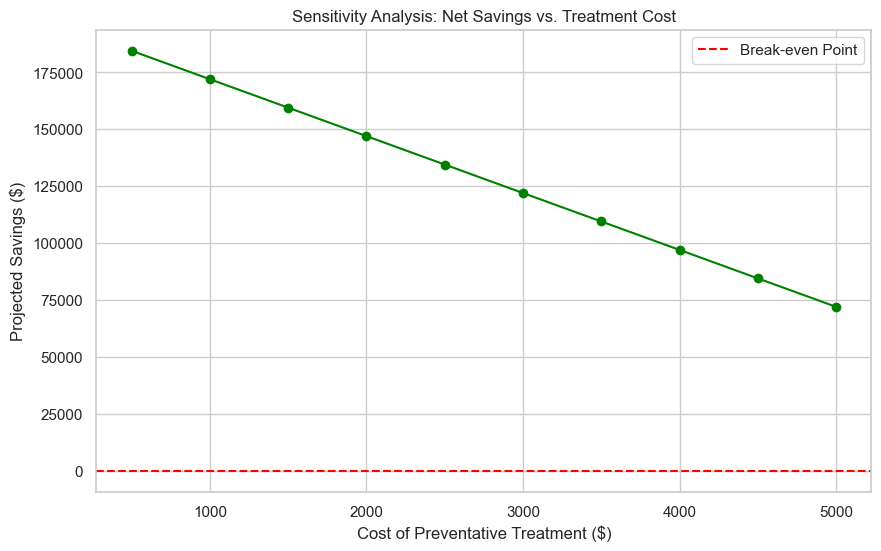

INSIGHT: As long as the treatment cost is below the break-even line, the model is profitable.


In [4]:
# Cell 4: Sensitivity Analysis (Visualization)
# "What if the cost of treatment increases?" 
# This fulfills the 'Scenario Planning' requirement.

treatment_costs = np.linspace(500, 5000, 10) # range from $500 to $5000
savings_list = []

for cost in treatment_costs:
    # Temporarily update the global variable logic for calculation
    current_cost_model = (
        (tp * cost) + 
        (fp * (COST_SCREENING + cost)) + 
        (fn * COST_STROKE_EVENT)
    )
    current_savings = cost_baseline - current_cost_model
    savings_list.append(current_savings)

plt.figure(figsize=(10, 6))
plt.plot(treatment_costs, savings_list, marker='o', color='green')
plt.axhline(0, color='red', linestyle='--', label='Break-even Point')
plt.title('Sensitivity Analysis: Net Savings vs. Treatment Cost')
plt.xlabel('Cost of Preventative Treatment ($)')
plt.ylabel('Projected Savings ($)')
plt.legend()
plt.grid(True)
plt.show()

# Insight generation
print("INSIGHT: As long as the treatment cost is below the break-even line, the model is profitable.")